In [1]:
# 공공 사업 제안 인사인트 도출(데이터분석을 바탕으로 문제 해결 아이디어 제시)

In [27]:
#%config Completer.use_jedi = False
#!pip uninstall jedi
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) 


In [3]:
df_yang_parking = pd.read_csv(r'C:\Users\User\Documents\1일차\서울특별시 양천구\서울시 양천구 공영주차장 안내 정보.csv', encoding = 'cp949')
df_yang_illegal_2023  =pd.read_csv(r"C:\Users\User\Documents\1일차\서울특별시 양천구\서울특별시 양천구_주정차위반단속현황_20231220.csv", encoding = 'cp949')
df_yang_illegal_2022  =pd.read_csv(r"C:\Users\User\Documents\1일차\서울특별시 양천구\서울특별시_양천구_주정차위반단속현황_20221231.csv", encoding = 'cp949')
df_seocho_parking  =pd.read_csv(r'C:\Users\User\Documents\1일차\서울특별시 서초구\서울시 서초구 공영주차장 안내 정보.csv', encoding = 'cp949')
df_seocho_illegal  =pd.read_csv(r"C:\Users\User\Documents\1일차\서울특별시 서초구\서울특별시 서초구_주정차단속 시간별 현황_20241231.csv", encoding = 'cp949')

In [5]:
# 양천, 서초 공영주차장 안내 정보 데이터 병합
df_merge = pd.concat([df_yang_parking, df_seocho_parking], axis=0)
df_merge.shape

(330, 39)

In [6]:
# 필요없는 칼럼 제거
'''

###중복행
주차장 종류명 
야간무료개방여부명
주차현황 정보 제공여부명
유무료구분명
토요일 유,무료 구분명
공휴일 유,무료 구분명

### 누락값이 많음
위도
경도
버스 관련 컬럼
'''
df_merge_drop = df_merge.drop(columns=['전화번호', '주차장명'
                                       ,'주차장코드','주차장 종류명'
                                       ,'야간무료개방여부명'
                                       ,'주차현황 정보 제공여부명'
                                       ,'유무료구분명'
                                       ,'최종데이터 동기화 시간'
                                       ,'토요일 유,무료 구분명'
                                       ,'공휴일 유,무료 구분명'
                                      ,'버스 기본 주차 요금'
                                      ,'버스 기본 주차 시간(분 단위)',
                                       '버스 추가 단위 시간(분 단위)'
                                       ,'버스 추가 단위 요금'
                                       ,'위도'
                                       ,'경도'
                                       ,'노상 주차장 관리그룹번호'
                                      ])

In [7]:
df_merge_drop.isnull().sum()

주소                    0
주차장 종류                0
운영구분                  0
운영구분명                 0
주차현황 정보 제공여부          0
총 주차면                 0
유무료구분                 0
야간무료개방여부              0
평일 운영 시작시각(HHMM)      0
평일 운영 종료시각(HHMM)      0
주말 운영 시작시각(HHMM)      0
주말 운영 종료시각(HHMM)      0
공휴일 운영 시작시각(HHMM)     0
공휴일 운영 종료시각(HHMM)     0
토요일 유,무료 구분           0
공휴일 유,무료 구분           0
월 정기권 금액             31
기본 주차 요금              0
기본 주차 시간(분 단위)        0
추가 단위 요금             10
추가 단위 시간(분 단위)       10
일 최대 요금              45
dtype: int64

## *누락값 채우기*

In [39]:
# 누락값이 있는 행이 모두 유료 주차장임을 확인

missing_monthly = df_merge_drop[df_merge_drop['월 정기권 금액'].isna()]
#missing_monthly = df_merge_drop[df_merge_drop['추가 단위 시간(분 단위)'].isna()]
#missing_monthly = df_merge_drop[df_merge_drop['추가 단위 요금'].isna()]
#missing_monthly = df_merge_drop[df_merge_drop['일 최대 요금'].isna()]

# 주소 분할

In [45]:
# 공백 기준으로 나누기
df_merge_drop[['구', '동', '번지']] = df_merge_drop['주소'].str.split(' ', n=2, expand=True)

# 결과 확인
df_merge_drop


,주소,주차장 종류,운영구분,운영구분명,주차현황 정보 제공여부,총 주차면,유무료구분,야간무료개방여부,평일 운영 시작시각(HHMM),평일 운영 종료시각(HHMM),주말 운영 시작시각(HHMM),주말 운영 종료시각(HHMM),공휴일 운영 시작시각(HHMM),공휴일 운영 종료시각(HHMM),"토요일 유,무료 구분","공휴일 유,무료 구분",월 정기권 금액,기본 주차 요금,기본 주차 시간(분 단위),추가 단위 요금,추가 단위 시간(분 단위),일 최대 요금,구,동,번지
0,양천구 목동 919-8,NW,1,시간제 주차장,0,186,Y,N,900,1900,0,0,0,0,Y,Y,70000.0,150,5,150.0,5.0,9000.0,양천구,목동,919-8
1,양천구 목동 914-5,NW,1,시간제 주차장,0,553,Y,N,0,2400,0,2400,0,2400,N,N,70000.0,150,5,150.0,5.0,9000.0,양천구,목동,914-5
2,양천구 목동 905-29,NW,1,시간제 주차장,0,20,Y,N,900,1900,0,0,0,0,Y,Y,70000.0,150,5,150.0,5.0,9000.0,양천구,목동,905-29
3,양천구 목동 905-21,NW,1,시간제 주차장,0,25,Y,N,900,1900,0,0,0,0,Y,Y,70000.0,150,5,150.0,5.0,9000.0,양천구,목동,905-21
4,양천구 목동 924-1,NS,1,시간제 주차장,0,1,Y,N,900,1900,900,1500,0,0,N,Y,0.0,250,5,250.0,5.0,0.0,양천구,목동,924-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,서초구 양재동 323-1,NW,1,시간제 주차장,0,31,Y,N,700,2100,700,2100,700,2100,N,N,120000.0,300,10,300.0,10.0,9000.0,서초구,양재동,323-1
54,서초구 방배동 493-3,NS,1,시간제 주차장,0,1,Y,N,1000,2300,1000,2300,0,0,N,Y,250.0,250,5,250.0,5.0,5.0,서초구,방배동,493-3
55,서초구 양재동 237-2,NW,3,시간제 + 거주자 주차장,0,48,Y,N,0,2400,0,2400,0,2400,N,N,140000.0,250,5,250.0,5.0,9000.0,서초구,양재동,237-2
56,서초구 반포동 118-3,NW,1,시간제 주차장,1,1186,Y,N,0,2400,0,2400,0,2400,N,N,140000.0,440,5,440.0,5.0,31600.0,서초구,반포동,118-3


### 1. 월 정기권 금액 누락값 채우기

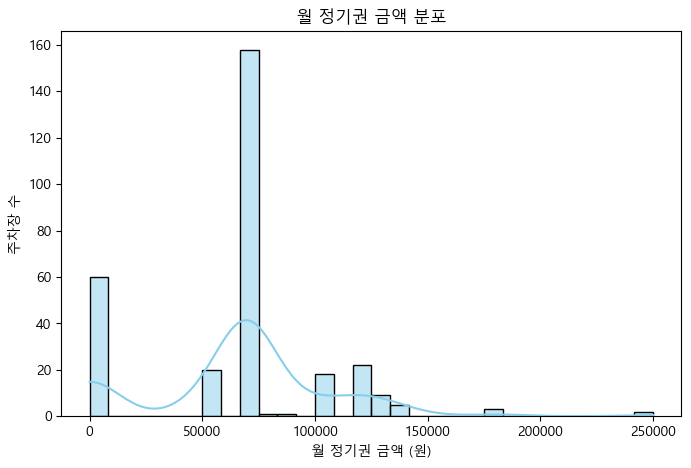

In [9]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.histplot(df_merge_drop['월 정기권 금액'], bins=30, kde=True, color='skyblue')
plt.title("월 정기권 금액 분포")
plt.xlabel("월 정기권 금액 (원)")
plt.ylabel("주차장 수")
plt.show()

In [10]:
most_common_fee = df_merge_drop['월 정기권 금액'].mode()[0]
print("가장 많은 월 정기권 금액:", most_common_fee)
df_merge_drop['월 정기권 금액'] = df_merge_drop['월 정기권 금액'].fillna(70000.0)

가장 많은 월 정기권 금액: 70000.0


### 월 정기권 금액,  추가 단위 요금

In [11]:
# 중앙갑으로 대체
df_merge_drop['추가 단위 요금'] = df_merge_drop['추가 단위 요금'].fillna(df_merge_drop['추가 단위 요금'].median())
df_merge_drop['추가 단위 시간(분 단위)'] = df_merge_drop['추가 단위 시간(분 단위)'].fillna(df_merge_drop['추가 단위 시간(분 단위)'].median())
df_merge_drop['일 최대 요금'] = df_merge_drop['일 최대 요금'].fillna(df_merge_drop['일 최대 요금'].median())

In [12]:
df_merge_drop.isnull().sum()

주소                   0
주차장 종류               0
운영구분                 0
운영구분명                0
주차현황 정보 제공여부         0
총 주차면                0
유무료구분                0
야간무료개방여부             0
평일 운영 시작시각(HHMM)     0
평일 운영 종료시각(HHMM)     0
주말 운영 시작시각(HHMM)     0
주말 운영 종료시각(HHMM)     0
공휴일 운영 시작시각(HHMM)    0
공휴일 운영 종료시각(HHMM)    0
토요일 유,무료 구분          0
공휴일 유,무료 구분          0
월 정기권 금액             0
기본 주차 요금             0
기본 주차 시간(분 단위)       0
추가 단위 요금             0
추가 단위 시간(분 단위)       0
일 최대 요금              0
dtype: int64

In [13]:
# 누락값 확인
df_merge_drop.isnull().sum()

주소                   0
주차장 종류               0
운영구분                 0
운영구분명                0
주차현황 정보 제공여부         0
총 주차면                0
유무료구분                0
야간무료개방여부             0
평일 운영 시작시각(HHMM)     0
평일 운영 종료시각(HHMM)     0
주말 운영 시작시각(HHMM)     0
주말 운영 종료시각(HHMM)     0
공휴일 운영 시작시각(HHMM)    0
공휴일 운영 종료시각(HHMM)    0
토요일 유,무료 구분          0
공휴일 유,무료 구분          0
월 정기권 금액             0
기본 주차 요금             0
기본 주차 시간(분 단위)       0
추가 단위 요금             0
추가 단위 시간(분 단위)       0
일 최대 요금              0
dtype: int64

In [14]:
# Unnamed 컬럼 제거 
df_yang_illegal_2022 = df_yang_illegal_2022.iloc[:, :7]

# 2022데이터에만 있는 견인지시 컬럼 제거
df_yang_illegal_2022_drop = df_yang_illegal_2022.drop(columns=['견인지시'])

# df_seocho_illegal의 과태료 원금 컬럼을 단속원금으로 수정 
df_seocho_illegal = df_seocho_illegal.rename(columns={'과태료 원금': '단속원금'})

# 주정차위반단속현황 데이터 병합
df_illegal_merge = pd.concat([df_yang_illegal_2022_drop, df_yang_illegal_2023,df_seocho_illegal], axis=0)
df_illegal_merge = df_illegal_merge.drop(columns=['연번'])

In [15]:
df_merge_drop.head()

,주소,주차장 종류,운영구분,운영구분명,주차현황 정보 제공여부,총 주차면,유무료구분,야간무료개방여부,평일 운영 시작시각(HHMM),평일 운영 종료시각(HHMM),주말 운영 시작시각(HHMM),주말 운영 종료시각(HHMM),공휴일 운영 시작시각(HHMM),공휴일 운영 종료시각(HHMM),"토요일 유,무료 구분","공휴일 유,무료 구분",월 정기권 금액,기본 주차 요금,기본 주차 시간(분 단위),추가 단위 요금,추가 단위 시간(분 단위),일 최대 요금
0,양천구 목동 919-8,NW,1,시간제 주차장,0,186,Y,N,900,1900,0,0,0,0,Y,Y,70000.0,150,5,150.0,5.0,9000.0
1,양천구 목동 914-5,NW,1,시간제 주차장,0,553,Y,N,0,2400,0,2400,0,2400,N,N,70000.0,150,5,150.0,5.0,9000.0
2,양천구 목동 905-29,NW,1,시간제 주차장,0,20,Y,N,900,1900,0,0,0,0,Y,Y,70000.0,150,5,150.0,5.0,9000.0
3,양천구 목동 905-21,NW,1,시간제 주차장,0,25,Y,N,900,1900,0,0,0,0,Y,Y,70000.0,150,5,150.0,5.0,9000.0
4,양천구 목동 924-1,NS,1,시간제 주차장,0,1,Y,N,900,1900,900,1500,0,0,N,Y,0.0,250,5,250.0,5.0,0.0


In [24]:
import matplotlib.pyplot as plt
# 사용자 운영체제 확인
import platform
platform.system()
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

# EDA

### 구별 주차장 수

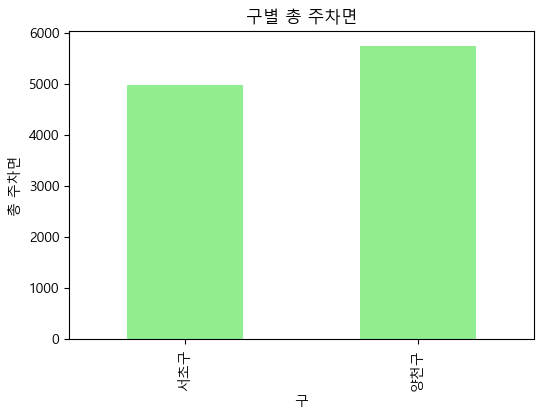

In [47]:
plt.figure(figsize=(6,4))
df_merge_drop.groupby('구')['총 주차면'].sum().plot(kind='bar', color='lightgreen')
plt.title("구별 총 주차면")
plt.xlabel("구")
plt.ylabel("총 주차면")
plt.show()

### 동별 주차장 수

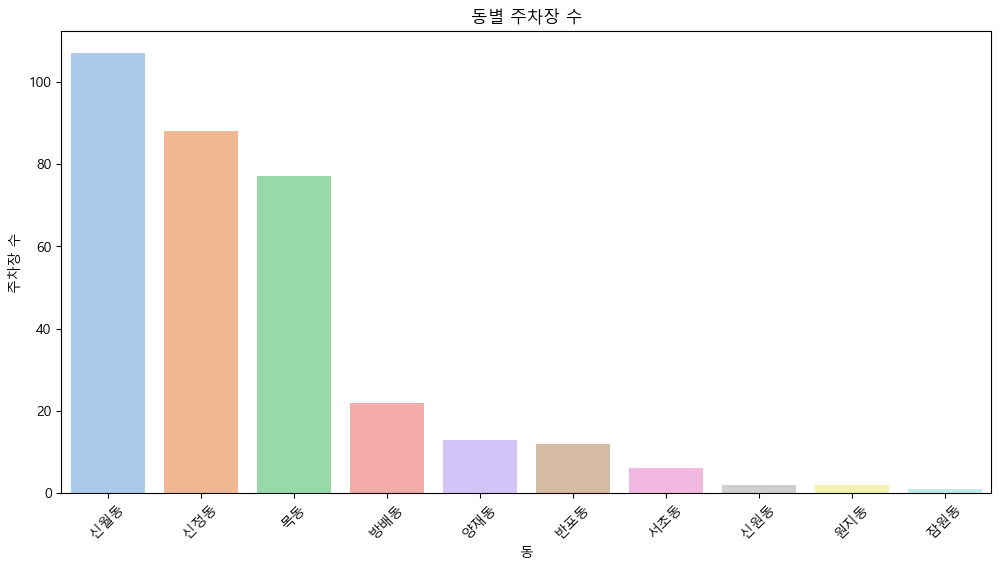

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.countplot(data=df_merge_drop, x='동', order=df_merge_drop['동'].value_counts().index, palette='pastel')
plt.title("동별 주차장 수")
plt.xlabel("동")
plt.ylabel("주차장 수")
plt.xticks(rotation=45)
plt.show()


### 동별 노외/노상 주차장 분포

<Figure size 1200x600 with 0 Axes>

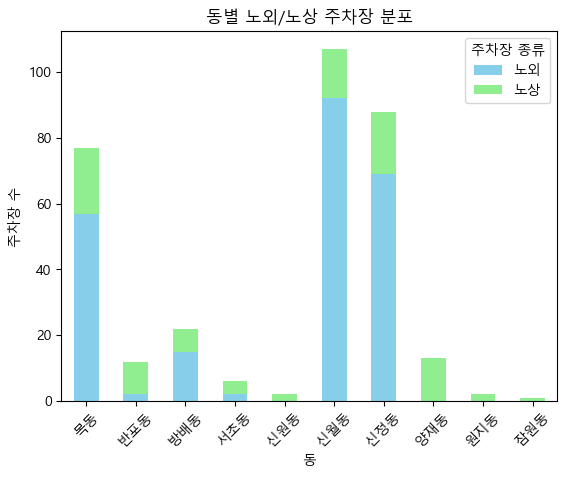

In [52]:
# 동별, 주차장 종류별 주차장 수
parking_type_count = df_merge_drop.groupby(['동', '주차장 종류']).size().unstack(fill_value=0)
parking_type_count.head()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
parking_type_count.plot(kind='bar', stacked=True, color=['skyblue', 'lightgreen'])
plt.title("동별 노외/노상 주차장 분포")
plt.xlabel("동")
plt.ylabel("주차장 수")
plt.xticks(rotation=45)
plt.legend(title='주차장 종류', labels=['노외', '노상'])
plt.show()


### 주차장 종류별 총 주차면 분포

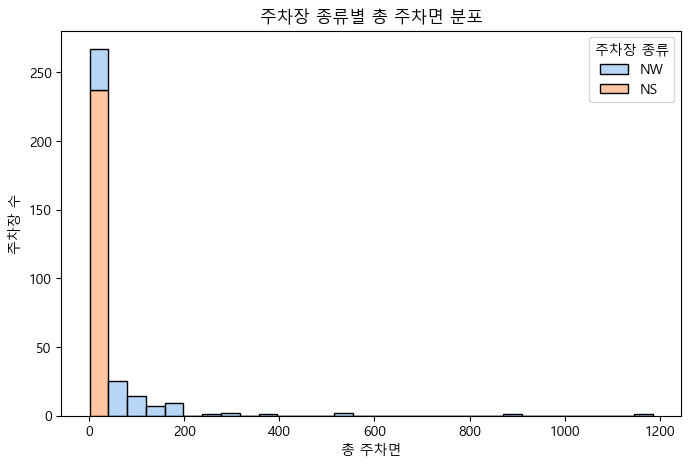

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_merge_drop, x='총 주차면', hue='주차장 종류', bins=30, multiple='stack', palette='pastel')
plt.title("주차장 종류별 총 주차면 분포")
plt.xlabel("총 주차면")
plt.ylabel("주차장 수")
plt.show()

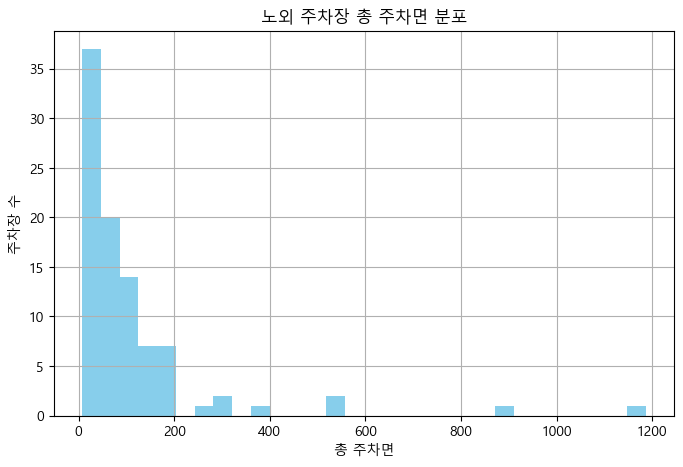

In [38]:
# 주차장 종류가 'NW'인 노외 주차장만 선택
noe_parking = df_merge_drop[df_merge_drop['주차장 종류'] == 'NW']
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
noe_parking['총 주차면'].hist(bins=30, color='skyblue')
plt.title("노외 주차장 총 주차면 분포")
plt.xlabel("총 주차면")
plt.ylabel("주차장 수")
plt.show()


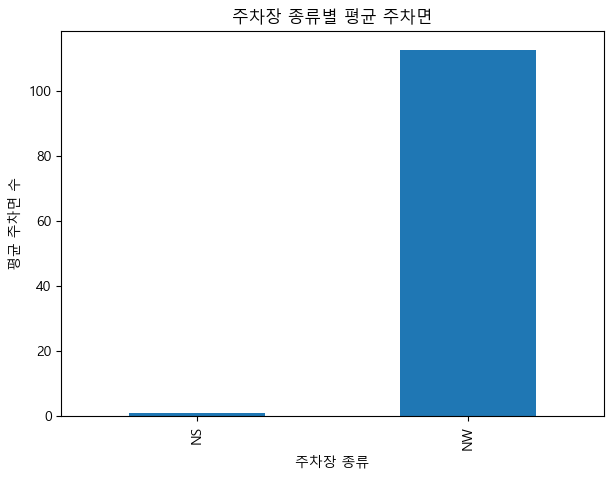

In [28]:
# 2. 주차장 종류별 평균 주차면
df_merge_drop.groupby("주차장 종류")["총 주차면"].mean().plot(kind='bar', figsize=(7,5))
plt.title("주차장 종류별 평균 주차면")
plt.ylabel("평균 주차면 수")
plt.show()

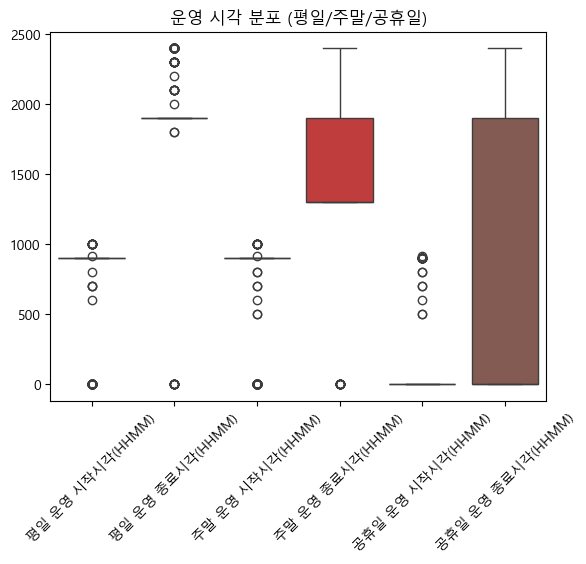

In [29]:
# 운영시간대 비교
import seaborn as sns

df_time = df_merge_drop[["평일 운영 시작시각(HHMM)", "평일 운영 종료시각(HHMM)",
                        "주말 운영 시작시각(HHMM)", "주말 운영 종료시각(HHMM)",
                        "공휴일 운영 시작시각(HHMM)", "공휴일 운영 종료시각(HHMM)"]]

sns.boxplot(data=df_time)
plt.title("운영 시각 분포 (평일/주말/공휴일)")
plt.xticks(rotation=45)
plt.show()


### 유료/무료 현황

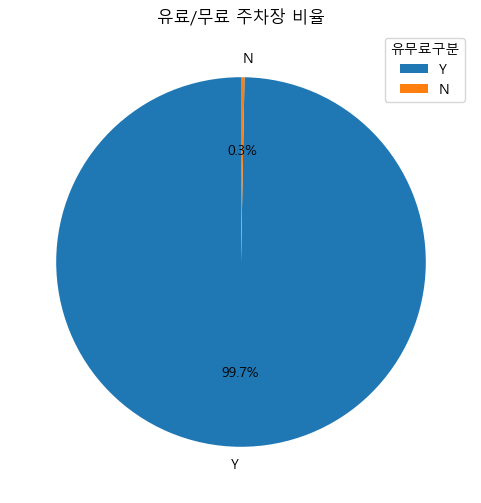

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
df_merge_drop['유무료구분'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=90  # 원을 시계 방향으로 회전
)
plt.title("유료/무료 주차장 비율")
plt.ylabel("")
plt.legend(title="유무료구분")  # 범례 추가
plt.show()



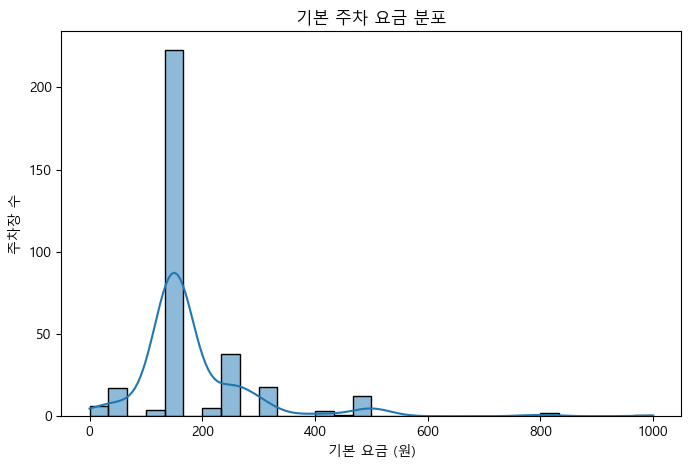

In [53]:
# 요금 체제 비교
plt.figure(figsize=(8,5))
sns.histplot(df_merge_drop['기본 주차 요금'], bins=30, kde=True)
plt.title("기본 주차 요금 분포")
plt.xlabel("기본 요금 (원)")
plt.ylabel("주차장 수")
plt.show()

In [57]:
most_common_fee = df_merge_drop['기본 주차 요금'].mode()[0]
print("기본 주차 요금", most_common_fee)

기본 주차 요금 150


In [58]:
df_illegal_merge

,단속일시,단속원금,단속동,단속장소,위반내용
0,2022-01-01 00:19,40000,목동,4동목동중앙본로5길 65-8,교통소통장애
1,2022-01-01 05:36,40000,신정동,4동중앙로300,횡단보도
2,2022-01-01 06:12,40000,목동,7동목동아파트123동,횡단보도
3,2022-01-01 09:45,40000,신월동,서울특별시 양천구 남부순환로 340,보도
4,2022-01-01 09:47,120000,신정동,7동목동@1214동앞,소화전
...,...,...,...,...,...
441777,2024-12-31 23:10,40000,서초4동,N05018 강남I-PARK애비뉴 주변,주차금지(황색점선)구역
441778,2024-12-31 23:18,40000,서초4동,N05018 강남I-PARK애비뉴 주변,주차금지(황색점선)구역
441779,2024-12-31 23:18,40000,방배동,서울특별시 서초구 도구로 123-8,보도
441780,2024-12-31 23:58,40000,반포동,"서울특별시 서초구 주흥17길 25 (반포동, 반포훼밀리",소화전


### 불법주정차 위반 상위 10개 동

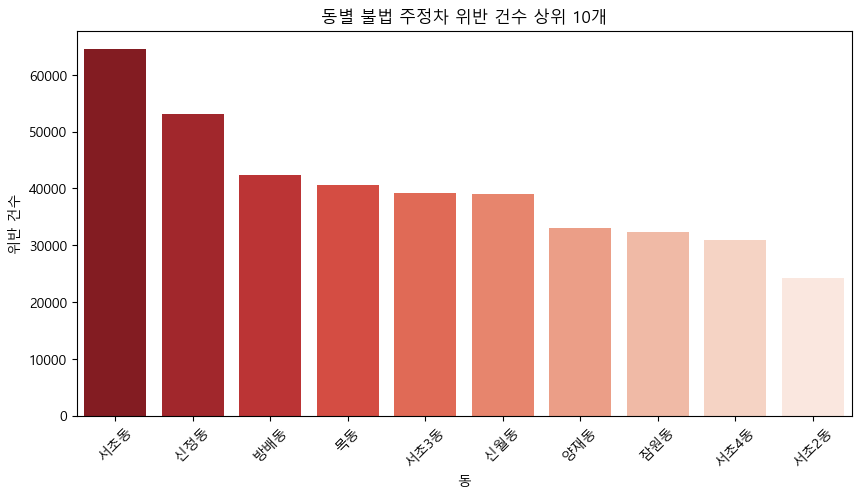

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# 동별 위반 건수
violation_count = df_illegal_merge.groupby('단속동').size().sort_values(ascending=False)

# 동별 위반 건수 계산 후 상위 10개
top10_violation = df_illegal_merge['단속동'].value_counts().head(10)
top10_violation

plt.figure(figsize=(10,5))
sns.barplot(x=top10_violation.index, y=top10_violation.values, palette='Reds_r')
plt.title("동별 불법 주정차 위반 건수 상위 10개")
plt.xlabel("동")
plt.ylabel("위반 건수")
plt.xticks(rotation=45)
plt.show()


### 주차장이 많은 곳 신정동, 방배동 신월동이 불법 주정차 위반 건수 상위 10개 동에 든다 => 교통량이 많아서 그런 것으로 추정

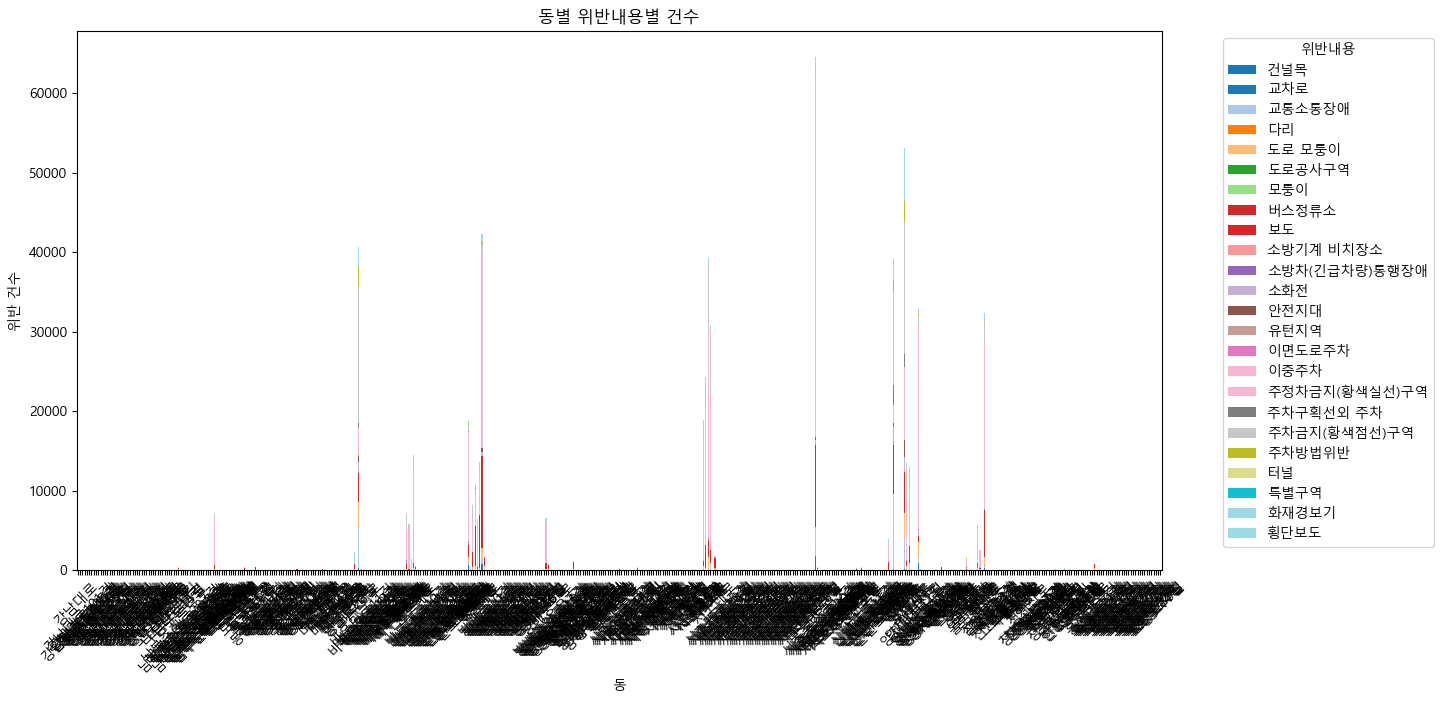

In [61]:
violation_type_count = df_illegal_merge.pivot_table(index='단속동', columns='위반내용', aggfunc='size', fill_value=0)

violation_type_count.plot(kind='bar', stacked=True, figsize=(14,7), colormap='tab20')
plt.title("동별 위반내용별 건수")
plt.xlabel("동")
plt.ylabel("위반 건수")
plt.xticks(rotation=45)
plt.legend(title='위반내용', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### 주차장 수가 적고불법 주정차 위반 건수가 많은 곳의 주차장을 늘린다.(방배 서초)